## Optimizing Model Prediction for Predicting Forest Fires

In this project we are going to use a standard linear regression model as a reference and the goal is to iterate on it using various tools for optimizing the machine learning workflow such as handling outliers, performing k-fold cross-validation, and using regularization — among others. Our machine learning task will be to predict the extent of fire damage to a forest. 

The data comes from the [Forest Fires](https://archive.ics.uci.edu/dataset/162/forest+fires) dataset from the UCI Machine Learning Repository. This dataset contains information on fires, along with the resulting damage and associated meteorological data. We want to know how these characteristics might be useful in predicting future fire damage.

![Image](https://images.unsplash.com/photo-1628666173519-66351692f747?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=774&q=80)
__Photo by Brett Jordan on Unsplash__

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
fires=pd.read_csv("C:/Users/Denisa/Desktop/Project Apps/project 23/fires.csv")
fires.columns

Index(['Unnamed: 0', 'X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI',
       'temp', 'RH', 'wind', 'rain', 'area'],
      dtype='object')

__Attribute Information__
*  `X` - x-axis spatial coordinate within the Montesinho park map: 1 to 9
*  `Y` - y-axis spatial coordinate within the Montesinho park map: 2 to 9
*  `month` - month of the year: 'jan' to 'dec' 
*  `day` - day of the week: 'mon' to 'sun'
*  `FFMC` - FFMC index from the FWI system: 18.7 to 96.20
*  `DMC` - DMC index from the FWI system: 1.1 to 291.3 
*  `DC` - DC index from the FWI system: 7.9 to 860.6 
*  `ISI` - ISI index from the FWI system: 0.0 to 56.10
*  `temp` - temperature in Celsius degrees: 2.2 to 33.30
*  `RH` - relative humidity in %: 15.0 to 100
*  `wind` - wind speed in km/h: 0.40 to 9.40 
*  `rain` - outside rain in mm/m2 : 0.0 to 6.4 
*  `area` - the burned area of the forest (in ha)

In [3]:
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


In [4]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


Based on the output above the dataset has 517 entires and 13 columns. Columns `month` and `day` have object data type, the rest of them are float or int. Some columns have missing values. The outcome of interest is the `area` column, which represents the total area damaged by the fire.

There is a considerable amount of missing data, so before we proceed with any model building or fitting we should  address this problem.

Unnamed:0 column is the same as the index and needs to be dropped. Specific day of the week is unlikely to be of much factor in forest fires and can be removed. 

We will also drop the `X` and `Y` columns as they do not have an ordinal property

In [5]:
fires.drop(['Unnamed: 0', 'X', 'Y', 'day'],axis=1, inplace=True)

### Data Visualization

Visualizations can help us understand how the features are related to the outcome. We will iterate through each of the features, and examine its univariate relationship with area

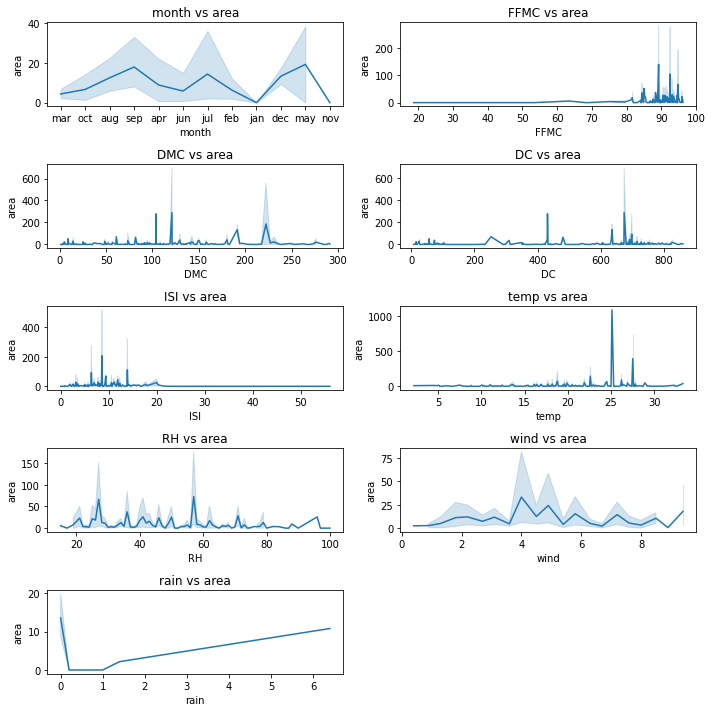

In [6]:
# generate list of predictive column 
column_names=fires.drop(columns=['area'])
column_names=column_names.columns

# set figsize
plt.figure(figsize=(10,10))

# loop through predictive column names and create lineplots with x=column name and y=outcome variable (area)
for i, col in enumerate(column_names):
  plt.subplot(5,2,i+1)
  sns.lineplot(data=fires, y='area', x=col) # seaborn lineplot
  plt.title(f'{col} vs area')

# show figure
plt.tight_layout()
plt.show() 

From the above plots we can conclude that:
* Fires are typically between May and September
* Fires corrospond to higher values of FFMC (fuel moisture of forest litter)
* Fires corrospond to about 100 DMC or greater (fuel moisture of decomposed organic material underneath the litter)
* Fires typically more severe with a DC (drying deep into the soil) of 400 or greater
* When ISI (initial spread index) is below 20 fires are more severe
* Higher temps correlate strongly with fire severity and size
* RH (relative humidity) has weak corrolation with fire severity
* Wind of 4 km/hour or greater typically increase fire area
* Times of little to no rain corrospond to larger fires, however increasing rains can also indicate increased risk of forest fire (probably because of lightning strikes).

Examining the distribution of the outcome column, area to determine if any transformations are necessary.

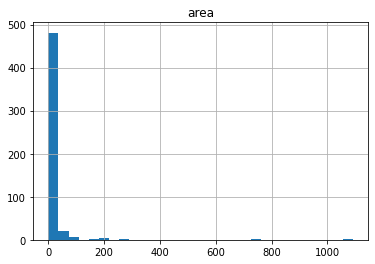

In [7]:
# Make copy of the dataset
fires_clean = fires.copy()

# Visualize the distribution of 'area'
fires_clean.hist('area', bins=30)
plt.show()

The outcome is highly right-skewed with extremely damaging fires. Furthermore, many of the rows have outcome values that are zero or near-zero. We should log-transform the data to reduce the effect of extreme values and make the distribution more symmetric. Some of the outcomes are actually 0, so we can add 1 to prevent any errors.

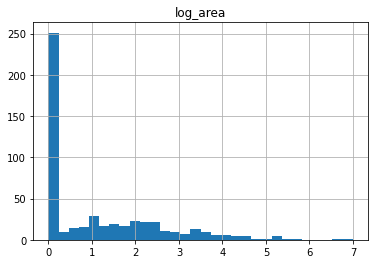

In [8]:
# Apply log transformation to the 'area'
fires_clean['log_area'] = np.log(fires_clean['area'] + 1) # add 1 to avoid taking the log of 0 or negative values

# Drop 'area'
fires_clean.drop('area', axis=1, inplace=True)

# Visualize the distribution of 'area' after log transformation
fires_clean.hist('log_area', bins=30)
plt.show()

Performing the log-transformation doesn't produce a bell-shaped distribution, but it does spread out the data a bit more than without the transformation.

We will derive a new feature called summer from the month column (1 if the fire occurred during summer months (jun, jul, aug), which are more prone to fires).

In [9]:
# Assign 1 to summer months otherwise assign 0
fires_clean['summer'] = fires_clean['month'].apply(lambda x: 1 if x in ['jun', 'jul', 'aug'] else 0)

In [10]:
# Drop the original 'month' and 'day' columns
fires_clean.drop(columns=['month'], axis=1, inplace=True)
fires_clean

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area,summer
0,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.000000,0
1,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.000000,0
2,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.000000,0
3,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.000000,0
4,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32.0,2.7,0.0,2.006871,1
513,81.6,56.7,665.6,1.9,21.9,71.0,5.8,0.0,4.012592,1
514,81.6,56.7,665.6,1.9,21.2,70.0,6.7,0.0,2.498152,1
515,94.4,146.0,614.7,11.3,25.6,42.0,4.0,0.0,0.000000,1


In [11]:
fires_clean.isnull().sum()

FFMC        48
DMC         21
DC          43
ISI          2
temp        21
RH          30
wind        35
rain        32
log_area     0
summer       0
dtype: int64

We can see our dataset contains some missing values. We will use he K-Nearest Neighbors Imputation to make an educated prediction and fill in missing values.

In [12]:
from sklearn.impute import KNNImputer

# Access column names containing missing values
miss_val_cols = fires_clean.columns[fires_clean.isnull().any()].tolist()

# Instantiate imputer
imputer = KNNImputer(missing_values=np.nan, n_neighbors=3) # n_neighbors=3 since we have small dataset

# Apply imputer and create dataframe
imputed_df = pd.DataFrame(imputer.fit_transform(fires_clean[miss_val_cols]),
                          columns=miss_val_cols)

# Check missing values after imputation
imputed_df.isnull().sum()

FFMC    0
DMC     0
DC      0
ISI     0
temp    0
RH      0
wind    0
rain    0
dtype: int64

Now we can use the imputed dataset in our machine learning workflow.

Now we can use the imputed dataset in our machine learning workflow.

In [13]:
for col in miss_val_cols:
    q1 = np.percentile(fires_clean[col], 25)
    q3 = np.percentile(fires_clean[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    outliers = ((fires_clean[col] < lower_bound) | (fires_clean[col] > upper_bound)).sum()
    print(f'{col}: {outliers} outliers')

FFMC: 0 outliers
DMC: 0 outliers
DC: 0 outliers
ISI: 0 outliers
temp: 0 outliers
RH: 0 outliers
wind: 0 outliers
rain: 0 outliers


 We'll examine the data for potential outliers, as they can be troublesome by influencing the estimation of model parameters, which harms model predictions.

Now that the dataset has been inspected for missing values and outliers, we can proceed to standardize it  to make sure that the coefficients are penalized similarly.

In [14]:
from sklearn.preprocessing import StandardScaler

# Instantiate scaler
scaler = StandardScaler()

# Apply scaler
scaled_imputed_df = scaler.fit_transform(imputed_df)

# Create dataframe from 'scaled_imputed_df'
scaled_imputed_df = pd.DataFrame(scaled_imputed_df, columns=miss_val_cols)

# Get columns in 'fires_clean' that are not in 'miss_val_cols'
non_miss_val_cols = fires_clean.columns[~fires_clean.columns.isin(miss_val_cols)]

# Concat 'fires_clean' and 'scaled_imputed_df'
fires_final = pd.concat([fires_clean[non_miss_val_cols], scaled_imputed_df], axis=1)
fires_final.head(105)

,log_area,summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0.0,0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,0.0,0,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,0.0,0,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0.0,0,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,0.0,0,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268
...,...,...,...,...,...,...,...,...,...,...
100,0.0,1,0.135001,0.497121,0.232058,0.347924,0.156543,-0.337468,0.780071,-0.073268
101,0.0,1,-0.338641,0.574419,0.285759,-0.003526,-0.779565,1.363969,-0.255181,-0.073268
102,0.0,1,0.754378,-0.040809,0.363646,1.753725,0.208549,-0.274452,-0.010485,-0.073268
103,0.0,0,0.335388,0.161112,0.531309,-0.091389,0.901963,-0.967629,0.271856,-0.073268


Text(0.5, 1.0, "Pearson's Correlation heatmap")

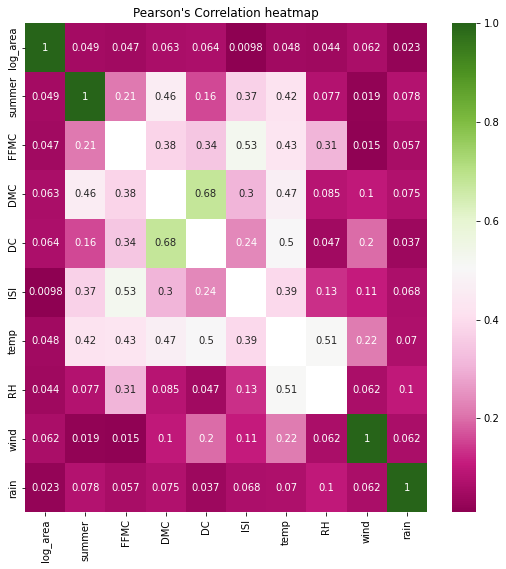

In [15]:
# calculate correlations in dataset
corr=abs(fires_final.corr())

# plot correlations using heatmap
plt.figure(figsize=(9,9))
sns.heatmap(corr[(corr<1)], cmap='PiYG', annot=True)
plt.title("Pearson's Correlation heatmap")

We can see that correlations of the predictor variables with the outcome variable area are not significant.

### Subset Selection

Now that we have a cleaned dataset with all numerical features and we've visually explored the feature-outcome relationships, we can start modeling. We will perform sequential feature selection, by choosing (forward) or eliminating (backward) a feature iteratively until a reasonable set is chosen. 

In [16]:
from sklearn.model_selection import train_test_split


# Create feature X and outcome y
X = fires_final.drop('log_area', axis=1)
y = fires_final['log_area']

# Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=42)

In [17]:
from sklearn.feature_selection import SequentialFeatureSelector


# Set up the forward selectors
forward_lm2 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=2,
                                        direction='forward')
forward_lm4 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=4,
                                        direction='forward')
forward_lm6 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=6,
                                        direction='forward')
forward_lm8 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=8,
                                        direction='forward')

# Fit the forward selectors
forward_lm2.fit(X_train, y_train)
forward_lm4.fit(X_train, y_train)
forward_lm6.fit(X_train, y_train)
forward_lm8.fit(X_train, y_train)

# Get the selected feature names from forward selectors
fwd_features2 = forward_lm2.get_feature_names_out()
fwd_features4 = forward_lm4.get_feature_names_out()
fwd_features6 = forward_lm6.get_feature_names_out()
fwd_features8 = forward_lm8.get_feature_names_out()

print(f'Forward selection - 2 feature model selected features: {fwd_features2}')
print(f'Forward selection - 4 feature model selected features: {fwd_features4}')
print(f'Forward selection - 6 feature model selected features: {fwd_features6}')
print(f'Forward selection - 8 feature model selected features: {fwd_features8}')

Forward selection - 2 feature model selected features: ['summer' 'DMC']
Forward selection - 4 feature model selected features: ['summer' 'FFMC' 'DMC' 'DC']
Forward selection - 6 feature model selected features: ['summer' 'FFMC' 'DMC' 'DC' 'ISI' 'wind']
Forward selection - 8 feature model selected features: ['summer' 'FFMC' 'DMC' 'DC' 'ISI' 'temp' 'RH' 'wind']


In [18]:
# Set up the backward selectors
backward_lm2 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=2,
                                        direction='backward')
backward_lm4 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=4,
                                        direction='backward')
backward_lm6 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=6,
                                        direction='backward')
backward_lm8 = SequentialFeatureSelector(estimator=LinearRegression(),
                                        n_features_to_select=8,
                                        direction='backward')

# Fit the backward selectors
backward_lm2.fit(X_train, y_train)
backward_lm4.fit(X_train, y_train)
backward_lm6.fit(X_train, y_train)
backward_lm8.fit(X_train, y_train)

# Get the selected feature names from backward selectors
bwd_features2 = backward_lm2.get_feature_names_out()
bwd_features4 = backward_lm4.get_feature_names_out()
bwd_features6 = backward_lm6.get_feature_names_out()
bwd_features8 = backward_lm8.get_feature_names_out()


print(f'Backward selection - 2 feature model selected features: {bwd_features2}')
print(f'Backward selection - 4 feature model selected features: {bwd_features4}')
print(f'Backward selection - 6 feature model selected features: {bwd_features6}')
print(f'Backward selection - 8 feature model selected features: {bwd_features8}')

Backward selection - 2 feature model selected features: ['DMC' 'ISI']
Backward selection - 4 feature model selected features: ['FFMC' 'DMC' 'DC' 'ISI']
Backward selection - 6 feature model selected features: ['FFMC' 'DMC' 'DC' 'ISI' 'temp' 'wind']
Backward selection - 8 feature model selected features: ['summer' 'FFMC' 'DMC' 'DC' 'ISI' 'temp' 'RH' 'wind']


In [19]:
# Find the common features in both forward and backward selectors
common_features2 = list(set(fwd_features2) & set(bwd_features2))
common_features4 = list(set(fwd_features4) & set(bwd_features4))
common_features6 = list(set(fwd_features6) & set(bwd_features6))
common_features8 = list(set(fwd_features8) & set(bwd_features8))

print(f'Common features in 2-feature model: {common_features2}')
print(f'Common features in 4-feature model: {common_features4}')
print(f'Common features in 6-feature model: {common_features6}')
print(f'Common features in 8-feature model: {common_features8}')

Common features in 2-feature model: ['DMC']
Common features in 4-feature model: ['FFMC', 'DMC', 'DC']
Common features in 6-feature model: ['DC', 'FFMC', 'wind', 'DMC', 'ISI']
Common features in 8-feature model: ['DC', 'temp', 'FFMC', 'RH', 'summer', 'wind', 'DMC', 'ISI']


Based on the selected features by both forward and backward selection, we can observe that the `dmc`, `ffmc` and `dc` features are the most common features selected in all models. Additionally, `wind` and `isi` are selected in the 6-feature model, and `summer` and '`rh` are selected in the 8-feature model. These features can be considered the most important predictors of the outcome variable `log_area` in the given dataset. 

In [20]:
# Fit Linear Regression models with selected features
fw2_model = LinearRegression().fit(X_train[fwd_features2], y_train)
fw4_model = LinearRegression().fit(X_train[fwd_features4], y_train)
fw6_model = LinearRegression().fit(X_train[fwd_features6], y_train)
fw8_model = LinearRegression().fit(X_train[fwd_features8], y_train)

bw2_model = LinearRegression().fit(X_train[bwd_features2], y_train)
bw4_model = LinearRegression().fit(X_train[bwd_features4], y_train)
bw6_model = LinearRegression().fit(X_train[bwd_features6], y_train)
bw8_model = LinearRegression().fit(X_train[bwd_features8], y_train)

### Developing Candidate Models

In the next step, we will consider incorporating regularized models like ridge or LASSO into our list of potential models.  They are powerful techniques that should be used when we are dealing with a large number of features (enhanincg the tendency of a model to overfit or causing computational challenges). Through regularization the models are simplified to generalize better to unseen dataIn standard linear regression, the coefficients are estimated by minimizing the mean squared error (MSE).The loss function for ridge regression is similar, but it adds an extra penalty term to the MSE that regularizes its coefficients. We will optimize the tuning parameter to select one that reduces validation error. 

We will also use the LASSO model. This regularization comes from an additional penalty term in the loss function that punishes high coefficient values with a different function (using the absolute values of the coefficients instead of their squared values). This gives LASSO a valuable characteristic that ridge regression lacks: feature selection because some of the coefficients might be forced to zero, effectively removing the associated feature from the model, unlike ridge regression where if we feed p features into the model, then we'll still retain all of them after the regularization.

Since one of the boundaries was chosen, we will modify the range for alphas.

For Lasso, given that the outcome has many small values, it suggests that having no features at all is better than having any. 

Linear regression models cannot account for non-linear trends present in some problems. To address this issue, we can consider using more flexible models such as polynomials and splines as candidate models.

In [21]:
from sklearn.linear_model import RidgeCV, LassoCV


# Define the alphas to search over
alphas = np.linspace(100, 1000, num=100)

# Create a ridge regression model
ridge_model = RidgeCV(alphas=alphas)
ridge_model.fit(X_train, y_train)

# Create a LASSO regression model
lasso_model = LassoCV(alphas=alphas)
lasso_model.fit(X_train, y_train)

print(f'Ridge tuning parameter: {ridge_model.alpha_}')
print(f'Ridge coefficients: {ridge_model.coef_}')
print()
print(f'Lasso tuning parameter: {lasso_model.alpha_}')
print(f'Lasso coefficients: {lasso_model.coef_}')

Ridge tuning parameter: 1000.0
Ridge coefficients: [-0.01586888  0.020451    0.03191785  0.01586458 -0.01002007  0.0064006
 -0.00606435  0.01080077  0.01244937]

Lasso tuning parameter: 1000.0
Lasso coefficients: [-0.  0.  0.  0. -0.  0. -0.  0.  0.]


In [22]:
# Redefine alphas with wider range and more values
alphas = np.linspace(15000, 20000, num=1000)

# Create a ridge regression model
ridge_model = RidgeCV(alphas=alphas)
ridge_model.fit(X_train, y_train)

# Create a LASSO regression model
lasso_model = LassoCV(alphas=alphas)
lasso_model.fit(X_train, y_train)

print(f'Ridge tuning parameter: {ridge_model.alpha_}')
print(f'Ridge coefficients: {ridge_model.coef_}')
print()
print(f'Lasso tuning parameter: {lasso_model.alpha_}')
print(f'Lasso coefficients: {lasso_model.coef_}')

Ridge tuning parameter: 18323.323323323322
Ridge coefficients: [-0.00073756  0.00194092  0.00272665  0.00174614 -0.00014937  0.00099919
 -0.00054882  0.00064182  0.0010472 ]

Lasso tuning parameter: 20000.0
Lasso coefficients: [-0.  0.  0.  0. -0.  0. -0.  0.  0.]


The LASSO tuning parameter seems to be on the extreme. Given that the outcome has many small values, it suggests that having no features at all is better than having any. We won't use a LASSO model here since the regularization results aren't helpful.

In [23]:
from sklearn.preprocessing import StandardScaler, SplineTransformer, PolynomialFeatures
from sklearn.metrics import mean_squared_error
# empty list to contain mse results for different knots/degree values
test_mses = []

for knots in range(2, 11):
    
    spline = SplineTransformer(degree=3, n_knots=knots)
    
    spline_X_train = spline.fit_transform(X_train)
    spline_X_test = spline.transform(X_test)
    
    model = LinearRegression()
    model.fit(spline_X_train, y_train)

    mse = mean_squared_error(y_test, model.predict(spline_X_test))
    test_mses.append(mse)
test_mses
spline = SplineTransformer(degree=3, n_knots=2)
X_spline = spline.fit_transform(X_train)


spline_model = LinearRegression()
spline_model.fit(X_spline, y_train)

spline_X_test = spline.transform(X_test)

spline_mse = mean_squared_error(y_test, spline_model.predict(spline_X_test))
spline_mse

2.210774450494947

### K-Fold Cross-Validation

Now that we have a few candidate models, let's evaluate all of them using k-fold cross-validation. We will incorporate K-fold cross-validation into our machine learning workflow by using multiple training and test sets using the original dataset and separate rounds of training. We know k=5 or k=10 is a good compromise between bias and variance

In [24]:
from sklearn.model_selection import cross_val_score


# Model-feature dictionary
models = {
    
    'fw2': (fw2_model, X_train[fwd_features2]),
    'fw4': (fw4_model, X_train[fwd_features4]),
    'fw6': (fw6_model, X_train[fwd_features6]),
    'fw8': (fw8_model, X_train[fwd_features8]),
    'bw2': (bw2_model, X_train[bwd_features2]),
    'bw4': (bw4_model, X_train[bwd_features4]),
    'bw6': (bw6_model, X_train[bwd_features6]),
    'bw8': (bw8_model, X_train[bwd_features8]),
    'ridge': (ridge_model, X_train),
    'spline': (spline_model, X_spline)
}

# Dictionary to store mse of all models after cross validation
results = {}
for model_name, (model, X_data) in models.items():
    cv_scores = cross_val_score(model, X_data, y_train, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = cv_scores

In [25]:
# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Model', 'Avg MSE', 'STD'])

# Loop through the models in the 'results' dictionary and add the average MSE and STD to the dataframe
for model, mse in results.items():
    model_df = pd.DataFrame({'Model': [model], 'Avg MSE': [mse.mean()], 'STD': [mse.std()]})
    results_df = pd.concat([results_df, model_df], ignore_index=True)

# View results
results_df

,Model,Avg MSE,STD
0,fw2,-1.883368,0.326589
1,fw4,-1.894218,0.315927
2,fw6,-1.918202,0.336405
3,fw8,-1.943426,0.331074
4,bw2,-1.891318,0.35132
5,bw4,-1.895958,0.336804
6,bw6,-1.914253,0.343819
7,bw8,-1.943426,0.331074
8,ridge,-1.893411,0.325133
9,spline,-6053.805072,12101.755247


### Examining Model Weaknesses

Now we will iterate through the models and evaluate their test MSE using k-fold cross-validation on the test set.

In [28]:
from sklearn.model_selection import cross_val_score


# Model-feature dictionary
models = {
    
    'fw2': (fw2_model, X_test[fwd_features2]),
    'fw4': (fw4_model, X_test[fwd_features4]),
    'fw6': (fw6_model, X_test[fwd_features6]),
    'fw8': (fw8_model, X_test[fwd_features8]),
    'bw2': (bw2_model, X_test[bwd_features2]),
    'bw4': (bw4_model, X_test[bwd_features4]),
    'bw6': (bw6_model, X_test[bwd_features6]),
    'bw8': (bw8_model, X_test[bwd_features8]),
    'ridge': (ridge_model, X_test),
    
    'spline': (spline_model, spline_X_test)
}

# Dictionary to store mse of all models after cross validation
results = {}
for model_name, (model, X_data) in models.items():
    cv_scores = cross_val_score(model, X_data, y_test, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = cv_scores
    
# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Model', 'Avg MSE', 'STD'])

# Loop through the models in the 'results' dictionary and add the average MSE and STD to the dataframe
for model, mse in results.items():
    model_df = pd.DataFrame({'Model': [model], 'Avg MSE': [mse.mean()], 'STD': [mse.std()]})
    results_df = pd.concat([results_df, model_df], ignore_index=True)

# View results
results_df

,Model,Avg MSE,STD
0,fw2,-2.250755,0.77261
1,fw4,-2.413841,0.759611
2,fw6,-2.552017,1.062767
3,fw8,-2.568967,0.897343
4,bw2,-2.327974,0.882512
5,bw4,-2.705571,1.117131
6,bw6,-2.47891,0.889065
7,bw8,-2.568967,0.897343
8,ridge,-2.214176,0.768072
9,spline,-9831474871555784704.0,12338714987166044160.0


The value of the MSE for the spline model suggests is is not a good alternative for this dataset. The ridge model has the lowest value for mse, followed by fw2. However, note that this is on the log-scale, so this suggests that the predictions are off by a magnitude of about 2.

### Conclusion

In this course, we added quite a few tools to our machine learning toolkit: imputation, outlier detection, regularization, k-fold cross-validation, and even non-linear models. The UCI repository notes that this is a "difficult regression task," and that was reflected in the test performance of the models in the solution. 